### BiLSTM으로 한국어 스팀 리뷰 감성 분류하기

스팀 리뷰 데이터에 대한 이해와 전처리

#### 1) 데이터 로드하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x1cb3d665630>)

In [3]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [4]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [5]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [6]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [7]:
print(total_data.isnull().values.any())

False


#### 2) 훈련 데이터와 테스트 데이터 분리하기

In [9]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


#### 3) 레이블의 분포 확인

<Axes: xlabel='label'>

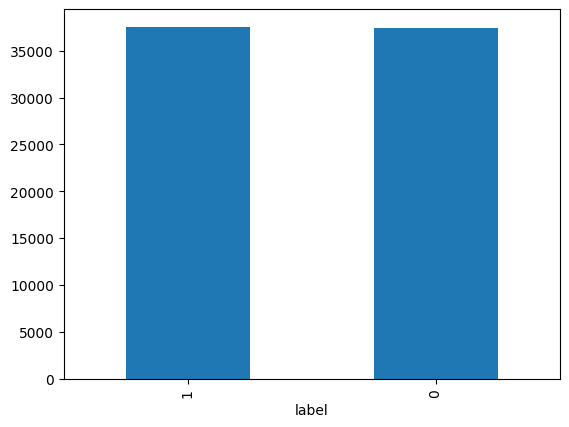

In [10]:
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  37376
1      1  37543


#### 4) 데이터 정제하기

In [12]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


C:\Users\82102\AppData\Local\Temp\ipykernel_23972\482251640.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)


In [13]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
print(test_data.isnull().sum())
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

label      0
reviews    0
dtype: int64
전처리 후 테스트용 샘플의 개수 : 24973


C:\Users\82102\AppData\Local\Temp\ipykernel_23972\3428150905.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [14]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네',
             '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

#### 5) 토큰화

In [15]:
mecab = Mecab(r'C:\mecab\mecab-ko-dic') 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


#### 6) 단어와 길이 분포 확인하기

In [16]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_words

array(['편', '나름', '재밌', ..., '금방', '끝', '남'], dtype='<U32')

In [17]:
len(negative_words), len(set(negative_words))

(571262, 22879)

In [33]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [34]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


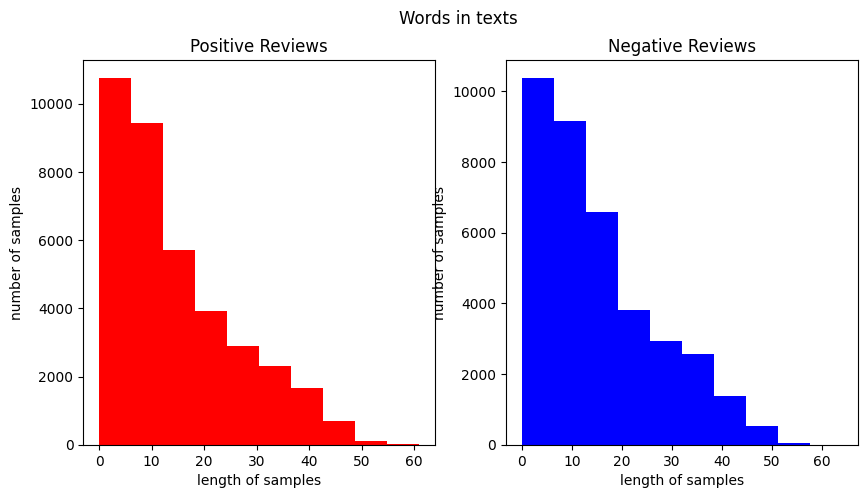

In [35]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()


In [36]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

#### 7) 정수 인코딩

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [39]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [40]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18941


In [41]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [44]:
print(X_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [43]:
print(X_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3518, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


#### 8) 패딩

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


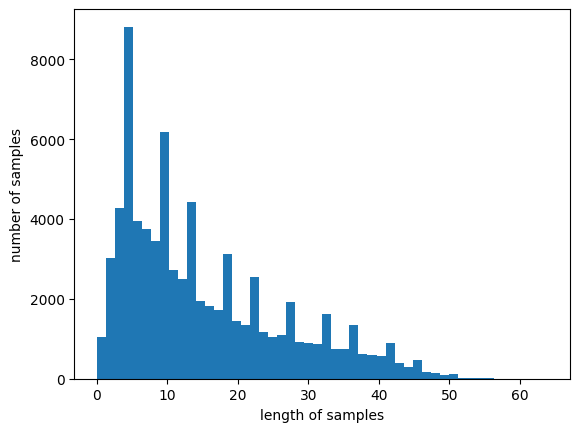

In [45]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [46]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [47]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


### 4. BiLSTM으로 스팀 리뷰 감성 분류하기

In [49]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [50]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)


Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - acc: 0.5848 - loss: 0.6612 
Epoch 1: val_acc improved from -inf to 0.73278, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 71s 288ms/step - acc: 0.5851 - loss: 0.6609 - val_acc: 0.7328 - val_loss: 0.5364
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - acc: 0.7738 - loss: 0.4840 
Epoch 2: val_acc improved from 0.73278 to 0.77776, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 74s 314ms/step - acc: 0.7738 - loss: 0.4839 - val_acc: 0.7778 - val_loss: 0.4785
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - acc: 0.7992 - loss: 0.4446  
Epoch 3: val_acc did not improve from 0.77776
235/235 ━━━━━━━━━━━━━━━━━━━━ 67s 286ms/step - acc: 0.7992 - loss: 0.4446 - val_acc: 0.7768 - val_loss: 0.4712
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - acc: 0.8127 - loss: 0.4196  
Epoch 4: val_acc improved from 0.77776 to 0.77796, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 66s 283ms/step - acc: 0.8127 - loss: 0.4196 - val_acc: 0.7780 - val_loss: 0.4749
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - acc: 0.8225 - loss: 0.4063 
Epoch 5: val_acc improved from 0.77796 to 0.78210, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 65s 275ms/step - acc: 0.8225 - loss: 0.4063 - val_acc: 0.7821 - val_loss: 0.4711
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - acc: 0.8338 - loss: 0.3862 
Epoch 6: val_acc did not improve from 0.78210
235/235 ━━━━━━━━━━━━━━━━━━━━ 74s 313ms/step - acc: 0.8338 - loss: 0.3862 - val_acc: 0.7820 - val_loss: 0.4668
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - acc: 0.8430 - loss: 0.3702 
Epoch 7: val_acc improved from 0.78210 to 0.78370, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 66s 279ms/step - acc: 0.8430 - loss: 0.3702 - val_acc: 0.7837 - val_loss: 0.4766
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - acc: 0.8483 - loss: 0.3569  
Epoch 8: val_acc did not improve from 0.78370
235/235 ━━━━━━━━━━━━━━━━━━━━ 66s 280ms/step - acc: 0.8483 - loss: 0.3570 - val_acc: 0.7826 - val_loss: 0.4828
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - acc: 0.8582 - loss: 0.3420 
Epoch 9: val_acc did not improve from 0.78370
235/235 ━━━━━━━━━━━━━━━━━━━━ 63s 269ms/step - acc: 0.8582 - loss: 0.3421 - val_acc: 0.7758 - val_loss: 0.4836
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - acc: 0.8670 - loss: 0.3248 
Epoch 10: val_acc did not improve from 0.78370
235/235 ━━━━━━━━━━━━━━━━━━━━ 63s 266ms/step - acc: 0.8670 - loss: 0.3248 - val_acc: 0.7789 - val_loss: 0.5077
Epoch 10: early stopping


In [51]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - acc: 0.7748 - loss: 0.4899
테스트 정확도: 0.7811


### 5. 리뷰 예측해보기

In [52]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [53]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
88.72% 확률로 부정 리뷰입니다.


C:\Users\82102\AppData\Local\Temp\ipykernel_23972\2747291277.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [54]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
98.12% 확률로 긍정 리뷰입니다.


C:\Users\82102\AppData\Local\Temp\ipykernel_23972\2747291277.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [55]:
sentiment_predict('케릭터가 예뻐서 좋아요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
81.06% 확률로 긍정 리뷰입니다.


C:\Users\82102\AppData\Local\Temp\ipykernel_23972\2747291277.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
67.38% 확률로 부정 리뷰입니다.


C:\Users\82102\AppData\Local\Temp\ipykernel_23972\2747291277.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측
